In [71]:
import numpy as np
import pandas as pd

In [72]:
data = pd.read_csv("../datasets/cleaned_data.csv")

In [73]:

cat_cols = ["Wall_Construction_Material", "Boiler", "Own_Type", "Climate_Zone"]
cont_cols = ["SQFT", "Number_Workers", "Building_Activity","Work_hours", "Cooling_Days", "Number_desktops", "Electricity_Consumption"]
target_col = "Electricity_Consumption"
columns =  cat_cols + cont_cols

In [74]:
def show_unique_values(df, cat_cols):
        """
        Prints the unique values for each categorical column in the DataFrame.
        
        Args:
        - df: DataFrame to inspect.
        - cat_cols: List of categorical column names.
        """
        print("-----------------[ Unique Values in Categorical Columns ]-----------------")
        for col in cat_cols:
            unique_vals = df[col].dropna().unique()  # Drop NaN values to exclude them
            print(f"{col}: {unique_vals.tolist()}")
            print(f"Total Unique (excluding NaN): {len(unique_vals)}\n")
def dataSummary(df, cat_cols, cont_cols):
    print("------------------------[ Shape ]------------------------\n", df.shape)
    print("------------------------[ Head ]------------------------\n",df.head)
    print("------------------------[ Columns ]------------------------\n",df.columns)
    print("------------------------[ describe ]------------------------\n",df.describe())
    missing_values = df.isnull().sum()
    print("------------------------[ Missing ]------------------------\n", missing_values)
    unique_counts = df.apply(lambda col: col.nunique(dropna=True))
    print("------------------------[ Unique Count ]------------------------\n", unique_counts)
    show_unique_values(df,cat_cols)
    
    
dataSummary(data[columns], cat_cols, cont_cols)
df = data[columns]

------------------------[ Shape ]------------------------
 (6436, 11)
------------------------[ Head ]------------------------
 <bound method NDFrame.head of       Wall_Construction_Material  Boiler  Own_Type  Climate_Zone      SQFT  \
0                            1.0     2.0       8.0           3.0  210000.0   
1                            1.0     2.0       2.0           4.0   28000.0   
2                            1.0     2.0       3.0           4.0    2100.0   
3                            2.0     1.0       1.0           5.0  240000.0   
4                            3.0     2.0       1.0           3.0  295000.0   
...                          ...     ...       ...           ...       ...   
6431                         1.0     1.0       9.0           2.0  130000.0   
6432                         1.0     2.0       1.0           4.0    1050.0   
6433                         2.0     2.0       2.0           4.0  122000.0   
6434                         3.0     2.0       3.0           4

In [77]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


def round_to_nearest_category(df, cat_cols, category_map):
    """
    Rounds imputed values in categorical columns to the nearest valid category.
    
    Args:
    - df: DataFrame with imputed values.
    - cat_cols: List of categorical column names.
    - category_map: Dictionary with column names as keys and valid categories as values.
    
    Returns:
    - DataFrame with corrected categorical columns.
    """
    for col in cat_cols:
        valid_categories = np.array(category_map[col])
        # Replace values with the nearest valid category
        df[col] = df[col].apply(lambda x: valid_categories[np.abs(valid_categories - x).argmin()])
    return df

def DataPreProcessing(df, cat_cols, cont_cols, category_map):
    df = df.dropna(subset=[target_col]).copy()

    # Impute missing values using KNNImputer
    imputer = KNNImputer(n_neighbors=15)
    df_imputed = pd.DataFrame(imputer.fit_transform(df[cat_cols + cont_cols]), columns=cat_cols + cont_cols)

    # Correct categorical columns by rounding to the nearest category
    df_imputed = round_to_nearest_category(df_imputed, cat_cols, category_map)
    
    scaler = MinMaxScaler()
    # scaler = StandardScaler()
    
    df_imputed[cont_cols] = scaler.fit_transform(df_imputed[cont_cols])

    return df_imputed, scaler


def DataPreProcessingMedianMode(df, cat_cols, cont_cols):
    """
    Preprocesses data by handling missing values:
    - Fills continuous columns with the median.
    - Fills categorical columns with the mode.
    - Normalizes continuous columns.

    Args:
    - df: DataFrame to process.
    - cat_cols: List of categorical column names.
    - cont_cols: List of continuous column names.

    Returns:
    - df_processed: DataFrame after preprocessing.
    - scaler: Fitted scaler object for continuous columns.
    """
    df_processed = df.copy()
    
    for col in cont_cols:
        median_val = df_processed[col].median()
        df_processed[col].fillna(median_val, inplace=True)
    
    for col in cat_cols:
        mode_val = df_processed[col].mode()[0]
        df_processed[col].fillna(mode_val, inplace=True)
    
    scaler = MinMaxScaler()
    df_processed[cont_cols] = scaler.fit_transform(df_processed[cont_cols])

    return df_processed, scaler

category_map = {
    "Wall_Construction_Material": [1.0, 2.0, 3.0, 5.0, 6.0, 8.0, 4.0, 7.0],
    "Boiler": [2.0, 1.0],
    "Own_Type": [8.0, 2.0, 3.0, 1.0, 10.0, 5.0, 9.0, 97.0, 4.0, 6.0, 7.0],
    "Climate_Zone": [3.0, 4.0, 5.0, 2.0, 7.0, 1.0]
}


df_imputed, scaler = DataPreProcessing(df, cat_cols, cont_cols, category_map)

dataSummary(df_imputed, cat_cols, cont_cols)

------------------------[ Shape ]------------------------
 (6436, 11)
------------------------[ Head ]------------------------
 <bound method NDFrame.head of       Wall_Construction_Material  Boiler  Own_Type  Climate_Zone      SQFT  \
0                            1.0     2.0       8.0           3.0  0.099571   
1                            1.0     2.0       2.0           4.0  0.012863   
2                            1.0     2.0       3.0           4.0  0.000524   
3                            2.0     1.0       1.0           5.0  0.113863   
4                            3.0     2.0       1.0           3.0  0.140066   
...                          ...     ...       ...           ...       ...   
6431                         1.0     1.0       9.0           2.0  0.061457   
6432                         1.0     2.0       1.0           4.0  0.000023   
6433                         2.0     2.0       2.0           4.0  0.057646   
6434                         3.0     2.0       3.0           4

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

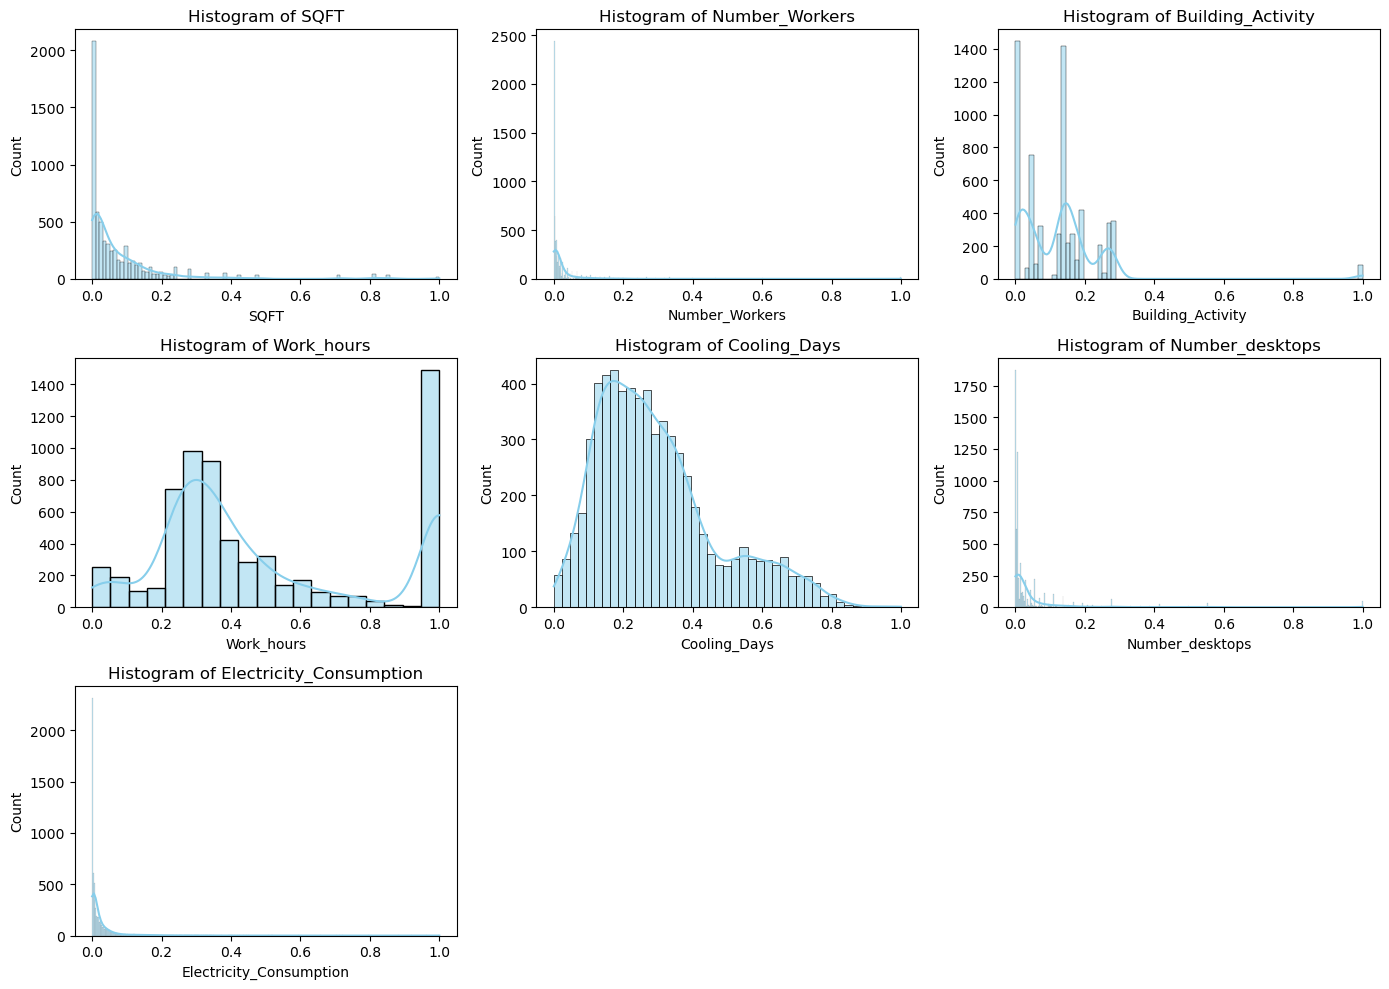

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

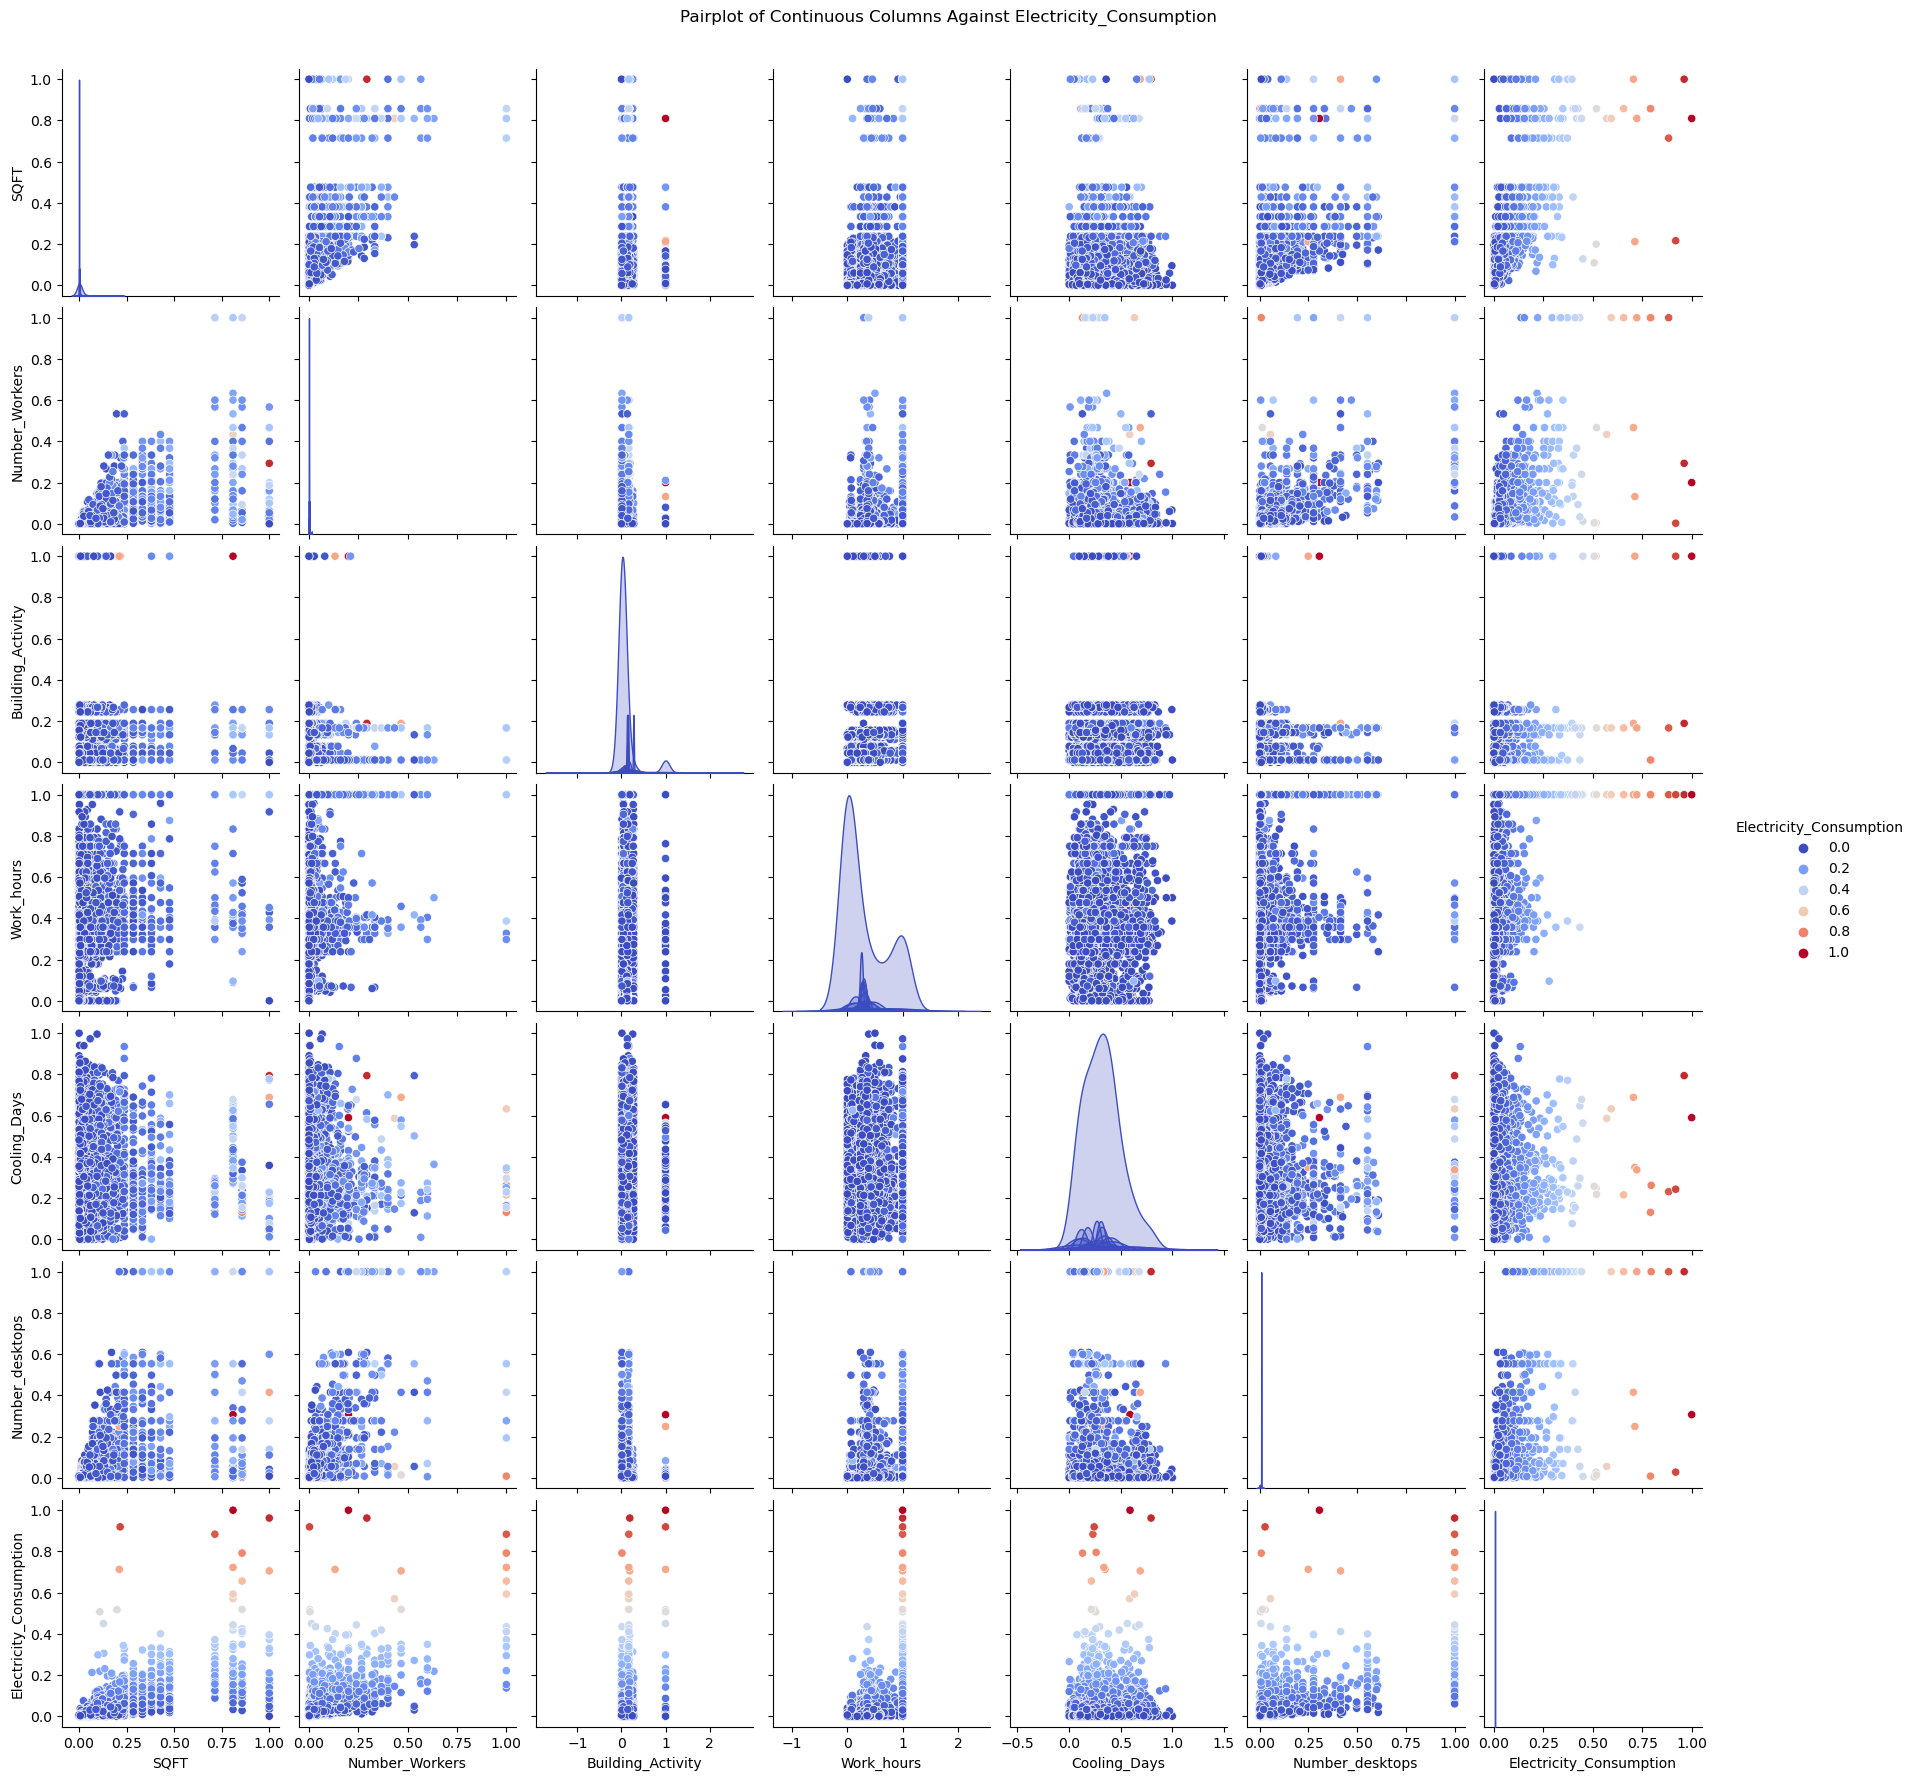

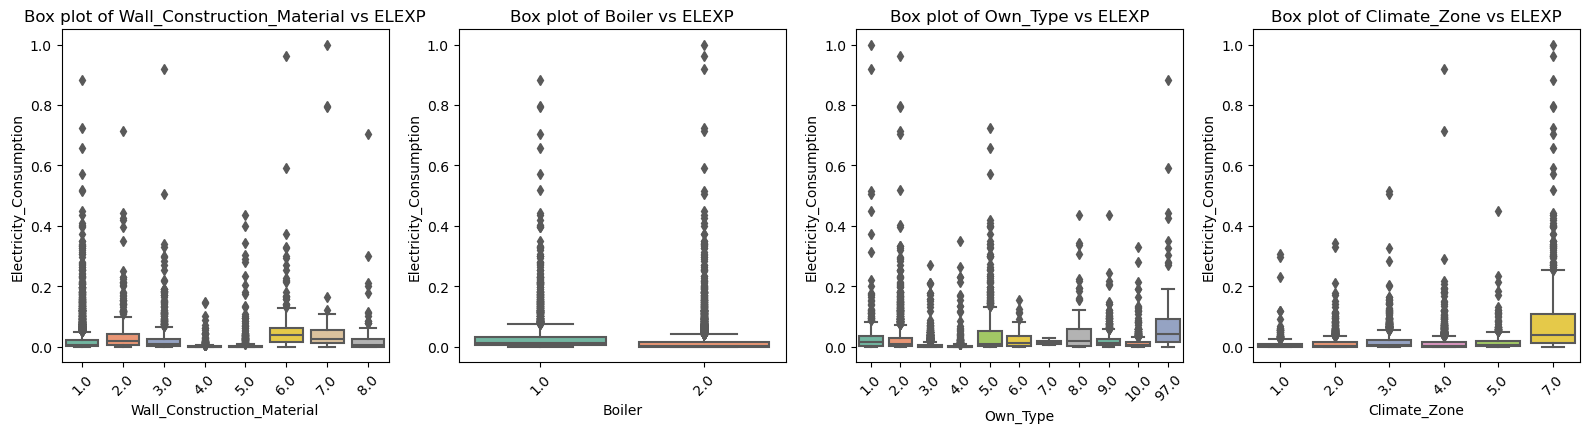

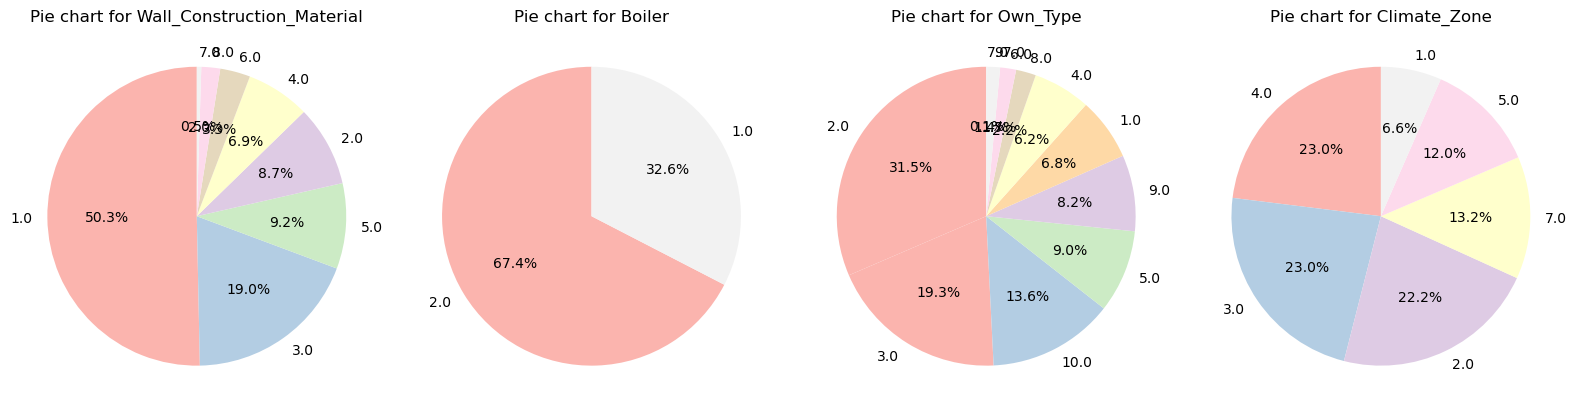

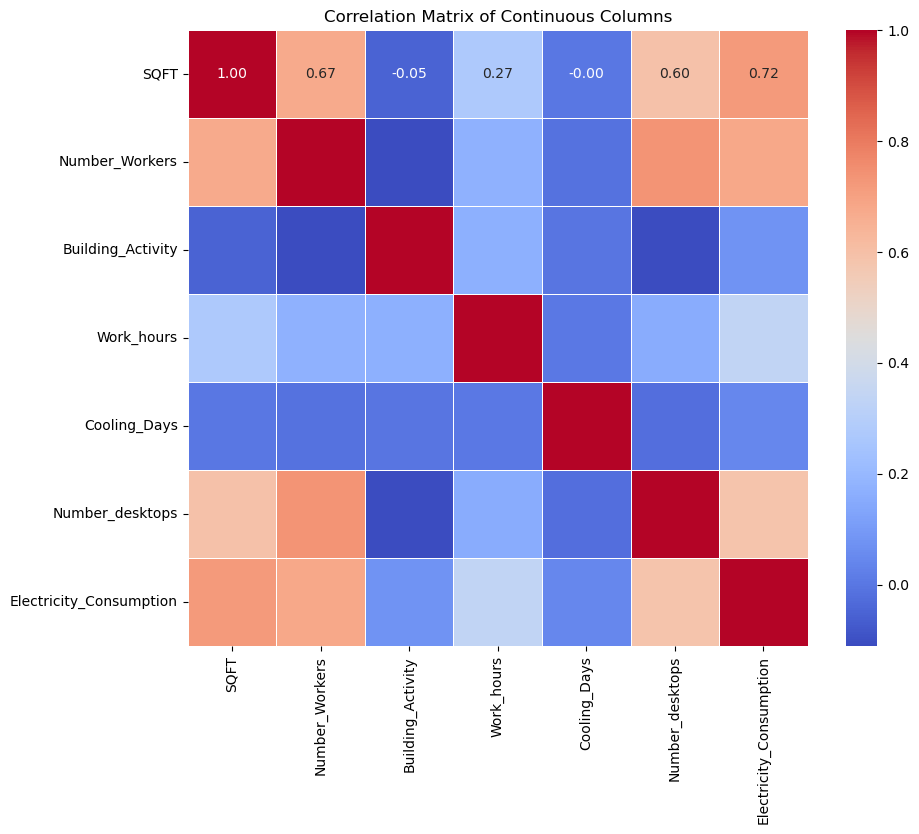

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

class DataExploration:
    def __init__(self, df, cat_cols, cont_cols, target_col):
        self.df = df.copy()
        self.cat_cols = cat_cols
        self.cont_cols = cont_cols
        self.target_col = target_col

    # 1. Plot Histograms for continuous columns
    def freedman_diaconis_bins(self, data):
        """Calculate optimal bin size using the Freedman-Diaconis rule"""
        data = data.replace([np.inf, -np.inf], np.nan).dropna()
        iqr = np.percentile(data, 75) - np.percentile(data, 25)
        n = len(data)
        bin_width = 2 * iqr / n**(1/3)
        
        if bin_width == 0:
            return 1  # Default to 1 bin if bin_width is zero
        
        bins = int((data.max() - data.min()) / bin_width)
        return bins


    def plot_histograms(self):
        plt.figure(figsize=(14, 10))
        for i, col in enumerate(self.cont_cols):
            
            bins = self.freedman_diaconis_bins(self.df[col].dropna())
            
            plt.subplot(3, 3, i + 1)
            sns.histplot(self.df[col], kde=True, bins=bins, color='skyblue')
            plt.title(f'Histogram of {col}')
        
        plt.tight_layout()
        plt.show()

    # 2. Pair plot for continuous columns vs ELEXP
    def plot_pairplot(self):
        sns.pairplot(self.df, vars=self.cont_cols, hue=self.target_col, palette='coolwarm')
        plt.suptitle(f"Pairplot of Continuous Columns Against {target_col}", y=1.02)
        plt.show()

    # 3. Box plot for categorical columns vs ELEXP
    def plot_boxplots(self):
        plt.figure(figsize=(16, 12))
        for i, col in enumerate(self.cat_cols):
            plt.subplot(3, 4, i + 1)
            sns.boxplot(x=self.df[col], y=self.df[self.target_col], palette='Set2')
            plt.title(f'Box plot of {col} vs ELEXP')
            plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # 4. Pie charts for categorical columns
    def plot_pie_charts(self):
        plt.figure(figsize=(16, 12))
        for i, col in enumerate(self.cat_cols):
            plt.subplot(3, 4, i + 1)
            self.df[col].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='Pastel1')
            plt.title(f'Pie chart for {col}')
            plt.ylabel('')
        plt.tight_layout()
        plt.show()

    # 5. Correlation matrix for continuous columns
    def plot_correlation_matrix(self):
        corr_matrix = self.df[self.cont_cols].corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title("Correlation Matrix of Continuous Columns")
        plt.show()

    # Combine all EDA functions into one call
    def perform_eda(self):
        self.plot_histograms()
        self.plot_pairplot()
        self.plot_boxplots()
        self.plot_pie_charts()
        self.plot_correlation_matrix()



import numpy as np

def remove_outliers(df):
    """
    Removes outliers in each column of the DataFrame using the IQR method.

    Args:
    - df: DataFrame from which outliers need to be removed.

    Returns:
    - df_no_outliers: DataFrame with outliers removed.
    """
    df_no_outliers = df.copy()
    
    for col in df_no_outliers.select_dtypes(include=np.number).columns:
        Q1 = df_no_outliers[col].quantile(0.25)
        Q3 = df_no_outliers[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & (df_no_outliers[col] <= upper_bound)]
    
    print(f"Shape of the data after removing outliers: {df_no_outliers.shape}")
    return df_no_outliers


# df_imputed[["ELCNS"]] = remove_outliers(df_imputed[["ELCNS"]])

eda = DataExploration(df_imputed, cat_cols, cont_cols, target_col=target_col)

eda.perform_eda()


In [79]:
df_imputed[target_col]

0       0.048214
1       0.003939
2       0.000135
3       0.005087
4       0.003326
          ...   
6431    0.006063
6432    0.006114
6433    0.030292
6434    0.002475
6435    0.032954
Name: Electricity_Consumption, Length: 6436, dtype: float64

In [80]:
import pandas as pd

def one_hot_encode(df, cat_cols, target_col):
    """
    Performs one-hot encoding on specified categorical columns and converts boolean to 1 and 0.

    Args:
    - df: DataFrame to encode.
    - cat_cols: List of categorical column names to one-hot encode.
    - target_col: The target column to exclude from encoding.

    Returns:
    - df_encoded: DataFrame with one-hot encoded columns (0 and 1).
    """
    df = df.copy()
    
    cat_cols = [col for col in cat_cols if col != target_col]
    
    df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    
    for col in df_encoded.columns:
        if df_encoded[col].dtype == bool:
            df_encoded[col] = df_encoded[col].astype(int)

    print(f"Shape after one-hot encoding: {df_encoded.shape}")
    
    return df_encoded

df_encoded = one_hot_encode(df_imputed, cat_cols, target_col)
df_encoded[target_col]

Shape after one-hot encoding: (6436, 30)


0       0.048214
1       0.003939
2       0.000135
3       0.005087
4       0.003326
          ...   
6431    0.006063
6432    0.006114
6433    0.030292
6434    0.002475
6435    0.032954
Name: Electricity_Consumption, Length: 6436, dtype: float64

In [81]:
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures

def feature_engineering(df, cat_cols, cont_cols, target_col):
    """
    Enhances a DataFrame by adding interaction terms, log, and polynomial transformations
    for the continuous columns, while leaving the target column unchanged.

    Args:
    - df: DataFrame to process.
    - cat_cols: List of categorical column names.
    - cont_cols: List of continuous column names.
    - target_col: Name of the target column (to remain unchanged).

    Returns:
    - df_transformed: DataFrame with new features added.
    """
    df_transformed = df.copy()
    
    cont_cols_no_target = [col for col in cont_cols if col != target_col]
    
    for col1, col2 in combinations(cont_cols_no_target, 2):
        interaction_col_name = f"{col1}_x_{col2}"
        df_transformed[interaction_col_name] = df_transformed[col1] * df_transformed[col2]
    
    for col in cont_cols_no_target:
        log_col_name = f"log_{col}"
        df_transformed[log_col_name] = np.log1p(df_transformed[col])  # Use log1p to avoid log(0) errors
    
    poly = PolynomialFeatures(degree=2, include_bias=False)
    poly_features = poly.fit_transform(df_transformed[cont_cols_no_target])
    poly_feature_names = poly.get_feature_names_out(cont_cols_no_target)
    
    poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df_transformed.index)
    df_transformed = pd.concat([df_transformed, poly_df], axis=1)
    
    df_transformed[target_col] = df[target_col]
    
    print(f"Shape after feature engineering: {df_transformed.shape}")
    return df_transformed

df_transformed = feature_engineering(df_encoded, cat_cols, cont_cols, target_col)
df_transformed.head()

Shape after feature engineering: (6436, 78)


,SQFT,Number_Workers,Building_Activity,Work_hours,Cooling_Days,Number_desktops,Electricity_Consumption,Wall_Construction_Material_2.0,Wall_Construction_Material_3.0,Wall_Construction_Material_4.0,...,Building_Activity^2,Building_Activity Work_hours,Building_Activity Cooling_Days,Building_Activity Number_desktops,Work_hours^2,Work_hours Cooling_Days,Work_hours Number_desktops,Cooling_Days^2,Cooling_Days Number_desktops,Number_desktops^2
0,0.099571,0.046667,0.011111,0.416667,0.310492,0.068899,0.048214,0,0,0,...,0.000123,0.004630,0.003450,0.000766,0.173611,0.129372,0.028708,0.096405,0.021392,4.747035e-03
1,0.012863,0.001600,0.011111,0.267857,0.031777,0.005257,0.003939,0,0,0,...,0.000123,0.002976,0.000353,0.000058,0.071747,0.008512,0.001408,0.001010,0.000167,2.763955e-05
2,0.000524,0.000800,0.077778,0.285714,0.424818,0.000277,0.000135,0,0,0,...,0.006049,0.022222,0.033041,0.000022,0.081633,0.121377,0.000079,0.180470,0.000118,7.656384e-08
3,0.113863,0.004533,0.044444,0.327381,0.538079,0.003874,0.005087,1,0,0,...,0.001975,0.014550,0.023915,0.000172,0.107178,0.176157,0.001268,0.289529,0.002084,1.500651e-05
4,0.140066,0.001333,0.044444,0.476190,0.231848,0.002490,0.003326,0,1,0,...,0.001975,0.021164,0.010304,0.000111,0.226757,0.110404,0.001186,0.053754,0.000577,6.201671e-06


In [82]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def run_ols(df, target_col):
    """
    Runs an OLS regression and finds significant features based on p-values.
    
    Args:
    - df_encoded: DataFrame containing encoded features and target column.
    - target_col: The name of the target column (dependent variable).
    
    Returns:
    - significant_features: List of features that are statistically significant.
    """
    X = df.drop(columns=[target_col])  # Features
    y = df[target_col]  # Target variable
    
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.dropna(inplace=True)
    y = y.loc[X.index]  # Align target column with cleaned X
    
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()
    
    summary = model.summary()
    print(summary)
    
    p_values = model.pvalues
    significant_features = p_values[p_values < 0.05].index.tolist()
    
    if 'const' in significant_features:
        significant_features.remove('const')
    
    return significant_features

significant_features = run_ols(df_transformed, target_col=target_col)
print(f"Significant features: {significant_features}")


                               OLS Regression Results                              
Dep. Variable:     Electricity_Consumption   R-squared:                       0.770
Model:                                 OLS   Adj. R-squared:                  0.768
Method:                      Least Squares   F-statistic:                     381.8
Date:                     Sat, 30 Nov 2024   Prob (F-statistic):               0.00
Time:                             14:09:19   Log-Likelihood:                 14130.
No. Observations:                     6436   AIC:                        -2.815e+04
Df Residuals:                         6379   BIC:                        -2.776e+04
Df Model:                               56                                         
Covariance Type:                 nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

In [83]:
X_train, X_test, y_train, y_test = train_test_split(
    df_transformed[significant_features], df_transformed[target_col], test_size=0.2, random_state=42
)

Final MSE loss: 0.0008


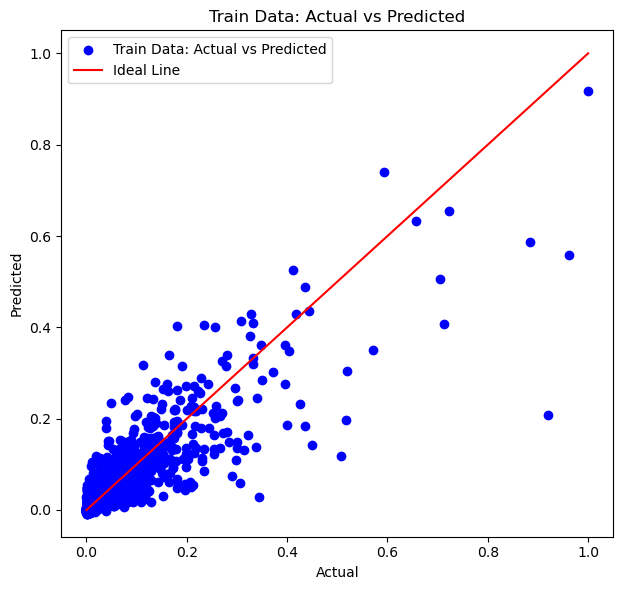

Train Accuracy: R2 = 0.7631, MSE = 0.0008
Test Accuracy: R2 = 0.7065, MSE = 0.0008


(0.763070154787881,
 0.0007786858981701247,
 0.7065135521267683,
 0.0007734916980108134)

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

class LinearRegressionModel:
    def __init__(self, df, target_col):
        """
        Initialize the model with data and columns.
        df: DataFrame, data including both features and target
        target_col: str, the name of the target column (dependent variable)
        cat_cols: list, categorical columns (if any)
        cont_cols: list, continuous columns (if any)
        """
        self.df = df
        self.target_col = target_col
        
        self.X = self.df.drop(columns=[self.target_col])
        self.y = self.df[target_col]
        
        self.model = LinearRegression()
        
    def fit(self, X_train, y_train):
        """
        Fit the linear regression model using sklearn's LinearRegression.
        X_train: Features for training
        y_train: Target variable for training
        """
        self.model.fit(X_train, y_train)
        
    def predict(self, X):
        """
        Predict the target variable for a given input matrix X.
        """
        return self.model.predict(X)

    def plot_metrics(self, X_train, y_train):
        """
        Plot loss over epochs and Test vs Predicted values.
        """
        train_pred = self.predict(X_train)
        
        loss = mean_squared_error(y_train, train_pred)
        print(f'Final MSE loss: {loss:.4f}')
        
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(y_train, train_pred, color='blue', label='Train Data: Actual vs Predicted')
        plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', label='Ideal Line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title('Train Data: Actual vs Predicted')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def accuracy(self, X_train, y_train, X_test, y_test):
        """
        Calculate the R2, MSE, and Accuracy (train and test).
        """
        train_pred = self.predict(X_train)
        train_r2 = r2_score(y_train, train_pred)
        train_mse = mean_squared_error(y_train, train_pred)
        
        test_pred = self.predict(X_test)
        test_r2 = r2_score(y_test, test_pred)
        test_mse = mean_squared_error(y_test, test_pred)

        print(f'Train Accuracy: R2 = {train_r2:.4f}, MSE = {train_mse:.4f}')
        print(f'Test Accuracy: R2 = {test_r2:.4f}, MSE = {test_mse:.4f}')
        
        return train_r2, train_mse, test_r2, test_mse




model = LinearRegressionModel(df_transformed, target_col)
model.fit(X_train, y_train)

model.plot_metrics(X_train, y_train)
model.accuracy(X_train, y_train, X_test, y_test)


Train Accuracy: R2 = 0.6661, MSE = 0.0011
Test Accuracy: R2 = 0.7178, MSE = 0.0007


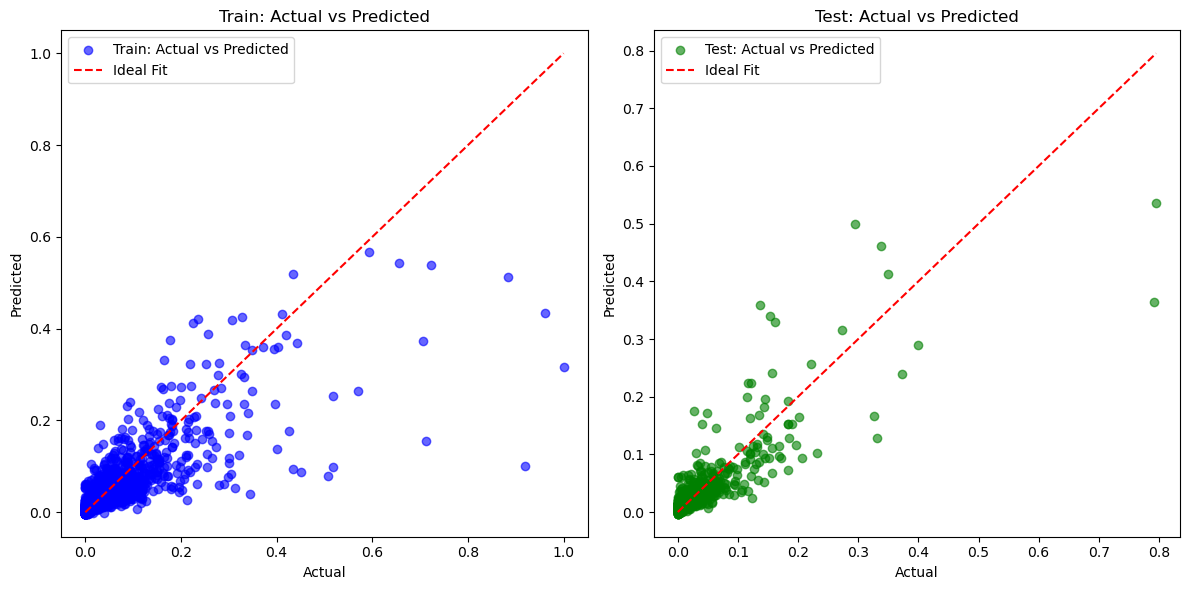

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import SGDRegressor

class SGDRegressionModel:
    def __init__(self, df, target_col):
        """
        Initialize the model with data and columns.
        df: DataFrame, data including both features and target
        target_col: str, the name of the target column (dependent variable)
        """
        self.df = df
        self.target_col = target_col
        
        # Prepare the feature and target matrices
        self.X = self.df.drop(columns=[self.target_col])
        self.y = self.df[self.target_col]
        
        # Initialize the SGD model
        self.model = SGDRegressor(random_state=42, max_iter=1000, tol=1e-3)
        
    def cross_validate(self, cv=5):
        """
        Perform k-fold cross-validation and print results.
        cv: int, number of folds (default is 5)
        """
        scoring = {
            'R2': 'r2',
            'MSE': make_scorer(mean_squared_error, greater_is_better=False)
        }
        
        results = cross_validate(self.model, self.X, self.y, cv=cv, scoring=scoring, return_train_score=True)
        
        print(f"Cross-Validation Results ({cv}-fold):")
        print(f"Train R2: {np.mean(results['train_R2']):.4f} ± {np.std(results['train_R2']):.4f}")
        print(f"Train MSE: {np.mean(results['train_MSE']):.4f} ± {np.std(results['train_MSE']):.4f}")
        print(f"Test R2: {np.mean(results['test_R2']):.4f} ± {np.std(results['test_R2']):.4f}")
        print(f"Test MSE: {np.mean(results['test_MSE']):.4f} ± {np.std(results['test_MSE']):.4f}")
        
        return results

    def fit(self, X_train, y_train):
        """
        Fit the SGD model using the training set.
        """
        self.model.fit(X_train, y_train)
        
    def predict(self, X):
        """
        Predict the target variable for a given input matrix X.
        """
        return self.model.predict(X)

    def accuracy(self, X_train, y_train, X_test, y_test):
        """
        Calculate the R2, MSE, and accuracy for train and test data.
        """
        # Train accuracy
        train_pred = self.predict(X_train)
        train_r2 = r2_score(y_train, train_pred)
        train_mse = mean_squared_error(y_train, train_pred)
        
        # Test accuracy
        test_pred = self.predict(X_test)
        test_r2 = r2_score(y_test, test_pred)
        test_mse = mean_squared_error(y_test, test_pred)

        print(f'Train Accuracy: R2 = {train_r2:.4f}, MSE = {train_mse:.4f}')
        print(f'Test Accuracy: R2 = {test_r2:.4f}, MSE = {test_mse:.4f}')
        
        return train_r2, train_mse, test_r2, test_mse

    def plot_predictions(self, X_train, y_train, X_test, y_test):
        """
        Plot Actual vs Predicted values for training and testing datasets.
        """
        # Predictions
        train_pred = self.predict(X_train)
        test_pred = self.predict(X_test)

        # Plot
        plt.figure(figsize=(12, 6))

        # Train Plot
        plt.subplot(1, 2, 1)
        plt.scatter(y_train, train_pred, alpha=0.6, label='Train: Actual vs Predicted', color='blue')
        plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--', label='Ideal Fit')
        plt.title('Train: Actual vs Predicted')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()

        # Test Plot
        plt.subplot(1, 2, 2)
        plt.scatter(y_test, test_pred, alpha=0.6, label='Test: Actual vs Predicted', color='green')
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')
        plt.title('Test: Actual vs Predicted')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()

        plt.tight_layout()
        plt.show()



sgd_model = SGDRegressionModel(df_transformed, target_col)
sgd_model.fit(X_train, y_train)
sgd_model.accuracy(X_train, y_train, X_test, y_test)
sgd_model.plot_predictions(X_train, y_train, X_test, y_test)



Tuning LinearRegression...
Tuning Ridge...
Tuning Lasso...
Tuning ElasticNet...
Model: LinearRegression, R2: 0.7065, MSE: 0.0008
Model: Ridge, R2: 0.6972, MSE: 0.0008
Model: Lasso, R2: -0.0008, MSE: 0.0026
Model: ElasticNet, R2: -0.0008, MSE: 0.0026
Best Model: LinearRegression


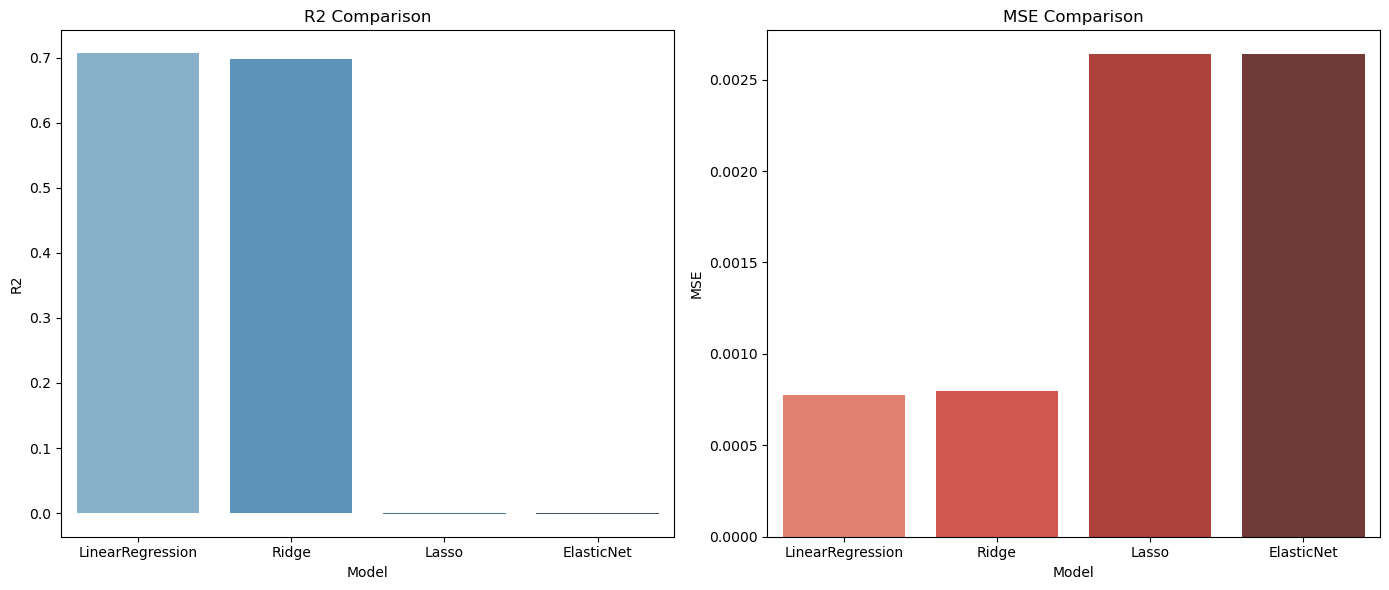

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

class HyperparameterTuning:
    def __init__(self, X_train, y_train, models=None):
        """
        Initialize the hyperparameter tuning process.

        X_train: Features for training
        y_train: Target variable for training
        models: Dictionary of models to be tuned (Optional)
        """
        self.X_train = X_train
        self.y_train = y_train
        
        # Default models if none are provided
        if models is None:
            self.models = {
                'LinearRegression': LinearRegression(),
                'Ridge': Ridge(),
                'Lasso': Lasso(),
                'ElasticNet': ElasticNet()
            }
        else:
            self.models = models
        
        self.param_grids = {
            'LinearRegression': {},
            'Ridge': {'alpha': [0.1, 1, 10, 100]},
            'Lasso': {'alpha': [0.1, 1, 10, 100]},
            'ElasticNet': {'alpha': [0.1, 1, 10, 100], 'l1_ratio': [0.1, 0.5, 0.9]},
        }

    def tune_model(self):
        best_models = {}
        for model_name, model in self.models.items():
            print(f"Tuning {model_name}...")
            
            param_grid = self.param_grids[model_name]
            
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
            grid_search.fit(self.X_train, self.y_train)

            best_models[model_name] = {
                'best_model': grid_search.best_estimator_,
                'best_params': grid_search.best_params_,
                'best_score': grid_search.best_score_
            }
        
        return best_models

    def evaluate_model(self, model, X_test, y_test):
        """
        Evaluate the model using R2 and MSE on the test set.
        """
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        return r2, mse

    def get_best_model(self, X_test, y_test):
        best_models = self.tune_model()

        best_model_name = None
        best_model = None
        best_score = -np.inf
        performance = {}
        
        for model_name, info in best_models.items():
            model = info['best_model']
            r2, mse = self.evaluate_model(model, X_test, y_test)
            
            performance[model_name] = {'R2': r2, 'MSE': mse}
            
            print(f"Model: {model_name}, R2: {r2:.4f}, MSE: {mse:.4f}")
            
            if r2 > best_score:
                best_score = r2
                best_model_name = model_name
                best_model = model
        
        print(f"Best Model: {best_model_name}")
        
        self.plot_performance_comparison(performance)
        
        return best_model

    def plot_performance_comparison(self, performance):
        """
        Plot R2 and MSE for each model.
        """
        
        performance_df = pd.DataFrame(performance).T
        performance_df.reset_index(inplace=True)
        performance_df.rename(columns={'index': 'Model'}, inplace=True)
        
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))
        
        sns.barplot(x='Model', y='R2', data=performance_df, ax=ax[0], palette='Blues_d')
        ax[0].set_title('R2 Comparison')
        ax[0].set_ylabel('R2')
        
        sns.barplot(x='Model', y='MSE', data=performance_df, ax=ax[1], palette='Reds_d')
        ax[1].set_title('MSE Comparison')
        ax[1].set_ylabel('MSE')

        plt.tight_layout()
        plt.show()


tuner = HyperparameterTuning(X_train, y_train)
best_model = tuner.get_best_model(X_test, y_test)


Train Metrics:
MSE: 0.0008
MAE: 0.0109
R2: 0.7530
Adjusted R2: 0.7513
MAPE: 5944692.7387%

Test Metrics:
MSE: 0.0008
MAE: 0.0108
R2: 0.6972
Adjusted R2: 0.6884
MAPE: 520.1475%



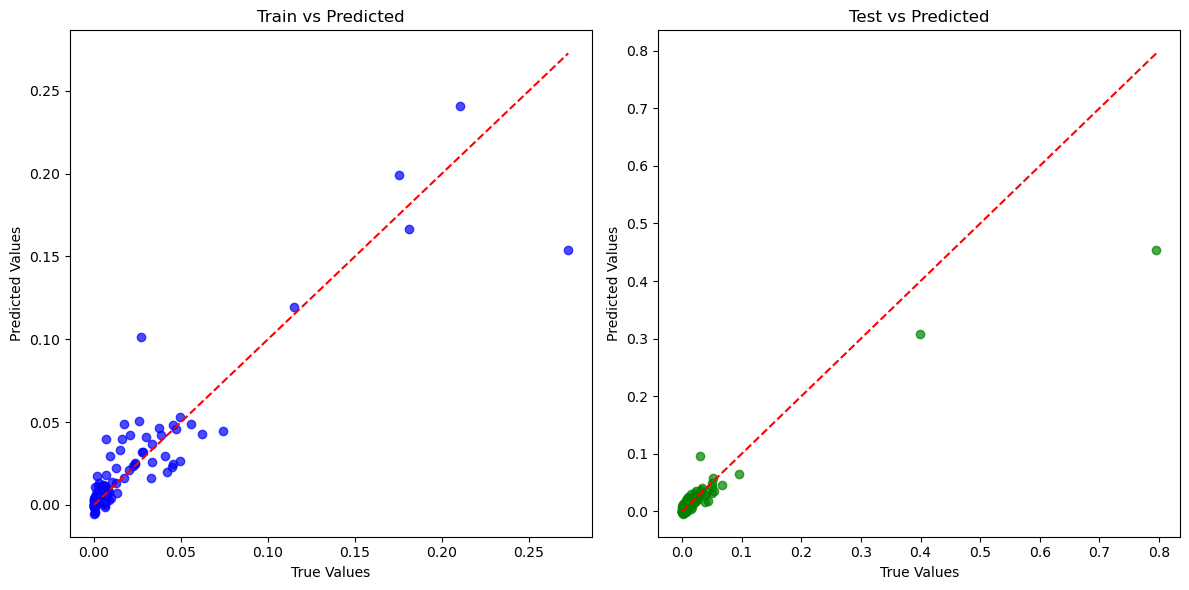

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

class RidgeModel:
    def __init__(self, alpha=1.0):
        """
        Initialize the Ridge regression model.
        
        Args:
        - alpha (float): Regularization strength (default is 1.0).
        """
        self.alpha = alpha
        self.model = Ridge(alpha=self.alpha)

    def train(self, X_train, y_train):
        """
        Train the Ridge regression model on the training data.
        
        Args:
        - X_train (DataFrame): The feature matrix for training.
        - y_train (Series): The target variable for training.
        """
        self.model.fit(X_train, y_train)

    def predict(self, X):
        """
        Make predictions using the trained Ridge regression model.
        
        Args:
        - X (DataFrame): The feature matrix for which predictions are made.
        
        Returns:
        - y_pred (array): The predicted values.
        """
        return self.model.predict(X)

    def evaluate(self, X_train, y_train, X_test, y_test):
        """
        Evaluate the model's performance on both train and test datasets.
        
        Args:
        - X_train (DataFrame): The feature matrix for training.
        - y_train (Series): The target variable for training.
        - X_test (DataFrame): The feature matrix for testing.
        - y_test (Series): The target variable for testing.
        
        Prints:
        - MSE, MAE, R2, Adjusted R2, and MAPE.
        """
        
        y_train_pred = self.predict(X_train)
        y_test_pred = self.predict(X_test)
        
        mse_train = mean_squared_error(y_train, y_train_pred)
        mae_train = mean_absolute_error(y_train, y_train_pred)
        r2_train = r2_score(y_train, y_train_pred)
        n_train = X_train.shape[0]
        p_train = X_train.shape[1]
        adjusted_r2_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p_train - 1)
        
        mse_test = mean_squared_error(y_test, y_test_pred)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        r2_test = r2_score(y_test, y_test_pred)
        n_test = X_test.shape[0]
        p_test = X_test.shape[1]
        adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p_test - 1)
        
        mape_train = np.mean(np.abs((y_train - y_train_pred) / (y_train + 1e-10))) * 100  # Add small epsilon to avoid division by zero
        mape_test = np.mean(np.abs((y_test - y_test_pred) / (y_test + 1e-10))) * 100  # Add small epsilon to avoid division by zero
        
        print("Train Metrics:")
        print(f"MSE: {mse_train:.4f}")
        print(f"MAE: {mae_train:.4f}")
        print(f"R2: {r2_train:.4f}")
        print(f"Adjusted R2: {adjusted_r2_train:.4f}")
        print(f"MAPE: {mape_train:.4f}%\n")
        
        print("Test Metrics:")
        print(f"MSE: {mse_test:.4f}")
        print(f"MAE: {mae_test:.4f}")
        print(f"R2: {r2_test:.4f}")
        print(f"Adjusted R2: {adjusted_r2_test:.4f}")
        print(f"MAPE: {mape_test:.4f}%\n")

    
    def plot_predictions(self, X_train, y_train, X_test, y_test):
        """
        Plot train vs predicted and test vs predicted values.
        
        Args:
        - X_train (DataFrame): The feature matrix for training.
        - y_train (Series): The target variable for training.
        - X_test (DataFrame): The feature matrix for testing.
        - y_test (Series): The target variable for testing.
        """
        # Predictions
        y_train_pred = self.predict(X_train)
        y_test_pred = self.predict(X_test)
        
        # Plot Train vs Predicted
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(y_train, y_train_pred, color='blue', alpha=0.7)
        plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
        plt.title("Train vs Predicted")
        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")
        
        # Plot Test vs Predicted
        plt.subplot(1, 2, 2)
        plt.scatter(y_test, y_test_pred, color='green', alpha=0.7)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
        plt.title("Test vs Predicted")
        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")
        
        plt.tight_layout()
        plt.show()


ridge_model = RidgeModel(alpha=1.0)
ridge_model.train(X_train, y_train)

ridge_model.evaluate(X_train, y_train, X_test, y_test)
n_for_plot = 100


ridge_model.plot_predictions(X_train[:n_for_plot], y_train[:n_for_plot], X_test[:n_for_plot], y_test[:n_for_plot])
